<a href="https://colab.research.google.com/github/Myeong-bin/test1/blob/main/chapter03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

#### 앞부분 코드 정리

In [ ]:
###### Constant tensors and variables ###### 텐서를 생성하는 다양한 방법들

# 모든 요소가 1로 이루어진 텐서 생성
import tensorflow as tf
x = tf.ones(shape=(2, 1))
print(x)

import numpy as np
np.ones((2,1))

# 모든 요소가 0인 텐서 생성
x = tf.zeros(shape=(2, 1))
print(x)

# 랜덤 텐서 생성 : 정규 분포에서 무작위로 값을 추출 3X1 텐서 생성
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)
print(x)

# 핸덤 텐서 생성 : 0과 1 사이의 균등 분포에서 값을 추출 3X1 텐서 생성
x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)
print(x)

# 넘파이 배열 이용 모든 요소가 1인 2X2 배열 생성
import numpy as np
x = np.ones(shape=(2, 2))
x[0, 0] = 0. # 첫 번째 요소를 0으로 변경

# TensorFlow의 변수를 생성, 초기값으로 평균이 0이고 표준 편차가 1인 정규 분포에서 값을 샘플링
#  3x1 크기의 텐서를 사용
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

# 변수 v에 모든 요소가 1로 이루어진 3x1 크기의 텐서를 할당
v.assign(tf.ones((3, 1)))

# 변수 v의 첫 번째 요소를 3으로 변경
v[0, 0].assign(3.)

# 변수 v에 3x1 크기의 텐서를 더함, 기존 변수 값에 각 요소가 1인 텐서를 더하는 것과 같음
v.assign_add(tf.ones((3, 1)))


###### A second look at the GradientTape API ###### 그래디언트 계산하기

# 변수 input_var에 대한 제곱 함수의 그래디언트를 계산
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
   result = tf.square(input_var)
gradient = tape.gradient(result, input_var) # 결과 추출

# 상수 input_const에 대한 제곱 함수의 그래디언트를 계산
input_const = tf.constant(3.)
with tf.GradientTape() as tape:
   tape.watch(input_const) # 상수이기 때문에 필요한 부분
   result = tf.square(input_const)
gradient = tape.gradient(result, input_const)

# 중첩된 GradientTape을 사용하여 속도와 가속도를 계산
time = tf.Variable(0.)
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape: # 위치 계산
        position =  4.9 * time ** 2
    speed = inner_tape.gradient(position, time)
acceleration = outer_tape.gradient(speed, time) # 속도 계산


###### An end-to-end example: A linear classifier in pure TensorFlow######

# 데이터 생성(2차원 가우시안 분포를 따르는 두 가지 클래스의 가상 데이터)
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class) # 음수 클래스의 입력 데이터를 생성
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class) # 양수 클래스의 입력 데이터를 생성

inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32) # 이들을 수직으로 쌓아 입력 행렬
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))


# 입력 데이터를 시각화하여 음수 클래스와 양수 클래스를 구분
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0]) # 음수 클래스는 파란색으로, 양수 클래스는 빨간색
plt.show()

# 모델 & 가중치 행렬 W & 편향 벡터 b 정의
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

def model(inputs):
    return tf.matmul(inputs, W) + b

# 제곱 손실 함수 정의
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

# 학습 단계 정의 by 그래디언트
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(targets, predictions)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

# 학습 반복(training_step 함수 호출 & 모델 학습 >> 각 단계에서 손실 출력)
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

# 결과 시각화 (모델의 결정 경계를 시각화 & 예측값을 기준으로 클래스 구분)
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

x = np.linspace(-1, 4, 100)
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

#### 뒷부분 코드 정리

데이터 준비 >> layer 정의 >> 모델 생성 >> 컴파일 >> 모델 학습 >> 데이터 예측 순서

In [ ]:
##### 사용자가 layer를 정의할 경우의 코드 #####
# 데이터 준비
num_validation_samples = int(0.3 * len(inputs))
val_inputs = inputs[:num_validation_samples]
val_targets = targets[:num_validation_samples]
training_inputs = inputs[num_validation_samples:]
training_targets = targets[num_validation_samples:]
# layer 정의
class SimpleDense(keras.layers.Layer):
    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim, self.units),
                                 initializer="random_normal")
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros")

    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y
# 모델 생성
model = keras.Sequential([
    SimpleDense(32, activation="relu"),
    SimpleDense(64, activation="relu"),
    SimpleDense(32, activation="relu"),
    SimpleDense(10, activation="softmax")
])
# 컴파일
model.compile(optimizer="rmsprop",
              loss="mean_squared_error",
              metrics=["accuracy"])
# 학습
history = model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    validation_data=(val_inputs, val_targets)
)
# 예측
predictions = model.predict(val_inputs)
print(predictions)


##### keras 이용할 경우 코드 #####
# 데이터 정의
num_validation_samples = int(0.3 * len(inputs))
val_inputs = inputs[:num_validation_samples]
val_targets = targets[:num_validation_samples]
training_inputs = inputs[num_validation_samples:]
training_targets = targets[num_validation_samples:]
# 모델 생성
from tensorflow.keras import layers
model = models.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(10, activation="softmax")
])
# 컴파일
model.compile(optimizer="rmsprop",
              loss="mean_squared_error",
              metrics=["accuracy"])
# 학습
history = model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    validation_data=(val_inputs, val_targets)
)
# 예측
predictions = model.predict(val_inputs)
print(predictions)

# Introduction to Keras and TensorFlow

## What's TensorFlow?

## What's Keras?

## Keras and TensorFlow: A brief history

## Setting up a deep-learning workspace

### Jupyter notebooks: The preferred way to run deep-learning experiments

### Using Colaboratory

#### First steps with Colaboratory

#### Installing packages with pip

#### Using the GPU runtime

## First steps with TensorFlow

#### Constant tensors and variables

**All-ones or all-zeros tensors**

In [ ]:
import tensorflow as tf
x = tf.ones(shape=(2, 1))
print(x)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)


In [ ]:
import numpy as np
np.ones((2,1))

array([[1.],
       [1.]])

In [ ]:
x = tf.zeros(shape=(2, 1))
print(x)

tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


**Random tensors**

In [ ]:
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)
print(x)

tf.Tensor(
[[0.8322686]
 [1.0442132]
 [1.2914292]], shape=(3, 1), dtype=float32)


In [ ]:
x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)
print(x)

tf.Tensor(
[[0.27286696]
 [0.39291954]
 [0.72118056]], shape=(3, 1), dtype=float32)


**NumPy arrays are assignable**

In [ ]:
import numpy as np
x = np.ones(shape=(2, 2))
x[0, 0] = 0.

**Creating a TensorFlow variable**

In [ ]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[ 0.7326048 ],
       [-0.22865163],
       [-0.8928335 ]], dtype=float32)>


**Assigning a value to a TensorFlow variable**

In [ ]:
v.assign(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

**Assigning a value to a subset of a TensorFlow variable**

In [ ]:
v[0, 0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

**Using `assign_add`**

In [ ]:
v.assign_add(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

#### Tensor operations: Doing math in TensorFlow

**A few basic math operations**

In [ ]:
a = tf.ones((2, 2))
b = tf.square(a)
c = tf.sqrt(a)
d = b + c
e = tf.matmul(a, b)
e *= d

#### A second look at the GradientTape API

**Using the `GradientTape`**

In [ ]:
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
   result = tf.square(input_var)
gradient = tape.gradient(result, input_var)

**Using `GradientTape` with constant tensor inputs**

In [ ]:
input_const = tf.constant(3.)
with tf.GradientTape() as tape:
   tape.watch(input_const)
   result = tf.square(input_const)
gradient = tape.gradient(result, input_const)

**Using nested gradient tapes to compute second-order gradients**

In [ ]:
time = tf.Variable(0.)
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        position =  4.9 * time ** 2
    speed = inner_tape.gradient(position, time)
acceleration = outer_tape.gradient(speed, time)

#### An end-to-end example: A linear classifier in pure TensorFlow

**Generating two classes of random points in a 2D plane**

In [ ]:
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)

**Stacking the two classes into an array with shape (2000, 2)**

In [ ]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

**Generating the corresponding targets (0 and 1)**

In [ ]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

**Plotting the two point classes**

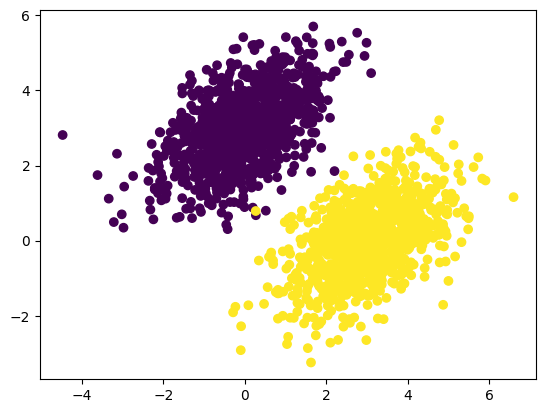

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

**Creating the linear classifier variables**

In [ ]:
# 여기서 b는 bias 부분임

input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

**The forward pass function**

In [ ]:
def model(inputs):
    return tf.matmul(inputs, W) + b

**The mean squared error loss function**

In [ ]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

**The training step function**

In [ ]:
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(targets, predictions)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

**The batch training loop**

In [ ]:
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 3.1608
Loss at step 1: 0.4882
Loss at step 2: 0.1783
Loss at step 3: 0.1323
Loss at step 4: 0.1190
Loss at step 5: 0.1103
Loss at step 6: 0.1027
Loss at step 7: 0.0959
Loss at step 8: 0.0897
Loss at step 9: 0.0840
Loss at step 10: 0.0788
Loss at step 11: 0.0741
Loss at step 12: 0.0697
Loss at step 13: 0.0658
Loss at step 14: 0.0621
Loss at step 15: 0.0588
Loss at step 16: 0.0558
Loss at step 17: 0.0531
Loss at step 18: 0.0505
Loss at step 19: 0.0482
Loss at step 20: 0.0461
Loss at step 21: 0.0442
Loss at step 22: 0.0425
Loss at step 23: 0.0409
Loss at step 24: 0.0394
Loss at step 25: 0.0381
Loss at step 26: 0.0368
Loss at step 27: 0.0357
Loss at step 28: 0.0347
Loss at step 29: 0.0338
Loss at step 30: 0.0329
Loss at step 31: 0.0321
Loss at step 32: 0.0314
Loss at step 33: 0.0308
Loss at step 34: 0.0302
Loss at step 35: 0.0297
Loss at step 36: 0.0292
Loss at step 37: 0.0287
Loss at step 38: 0.0283
Loss at step 39: 0.0279


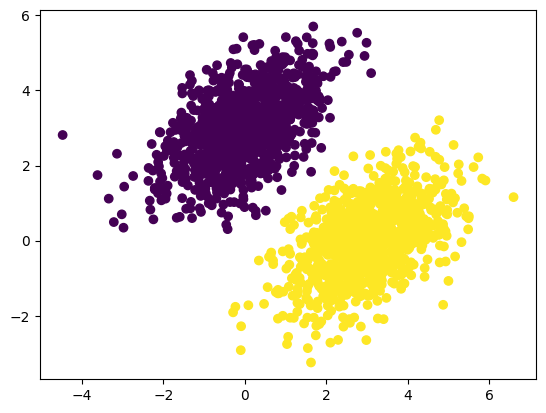

In [ ]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

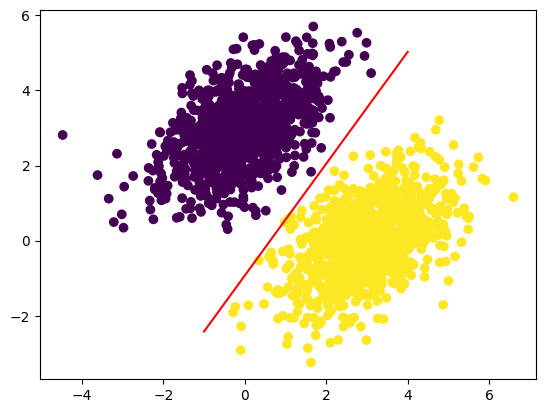

In [ ]:
x = np.linspace(-1, 4, 100)
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

## Anatomy of a neural network: Understanding core Keras APIs

### Layers: The building blocks of deep learning

In [ ]:
###### Layers: The building blocks of deep learning ######

from tensorflow import keras

# layer (1) 사용자 정의
class SimpleDense(keras.layers.Layer): # 가중치와 편향을 갖는 dense layer 정의

    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim, self.units),
                                 initializer="random_normal")
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros")

    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y

# layer 예시
my_dense = SimpleDense(units=32, activation=tf.nn.relu)
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

# layer (2) keras 내장
from tensorflow.keras import layers
layer = layers.Dense(32, activation="relu")


###### The "compile" step: Configuring the learning process ######

# 모델 생성 (1) (사용자 정의 층 사용)
model = keras.Sequential([
    SimpleDense(32, activation="relu"),
    SimpleDense(64, activation="relu"),
    SimpleDense(32, activation="relu"),
    SimpleDense(10, activation="softmax")
])

# 모델 생성 (2) (keras 내장 사용)
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(32)
])

# 컴파일 (1) 사용자 정의 : 옵티마이저, 손실 함수, 평가 지표 설정
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer="rmsprop",
              loss="mean_squared_error",
              metrics=["accuracy"])

# 컴파일 (2) keras
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

###### Picking a loss function ######

# 모델 학습
history = model.fit(
    inputs,
    targets,
    epochs=5,
    batch_size=128
)

history.history

###### Monitoring loss and metrics on validation data ######

# 모델 생성 및 컴파일
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

# 입력 데이터와 대상 데이터 섞기
indices_permutation = np.random.permutation(len(inputs))
shuffled_inputs = inputs[indices_permutation]
shuffled_targets = targets[indices_permutation]

# 검증 데이터 분할
num_validation_samples = int(0.3 * len(inputs))
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]

# 모델 학습
model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    validation_data=(val_inputs, val_targets)
)

###### Inference: Using a model after training ######
# 예측값 출력
predictions = model.predict(val_inputs, batch_size=128)
print(predictions[:10])

#### The base Layer class in Keras

**A `Dense` layer implemented as a `Layer` subclass**

In [ ]:
from tensorflow import keras

class SimpleDense(keras.layers.Layer):

    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim, self.units),
                                 initializer="random_normal")
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros")

    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y

In [ ]:
my_dense = SimpleDense(units=32, activation=tf.nn.relu)
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 32)


#### Automatic shape inference: Building layers on the fly

In [ ]:
from tensorflow.keras import layers
layer = layers.Dense(32, activation="relu")

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(32)
])

In [ ]:
model = keras.Sequential([
    SimpleDense(32, activation="relu"),
    SimpleDense(64, activation="relu"),
    SimpleDense(32, activation="relu"),
    SimpleDense(10, activation="softmax")
])

### From layers to models

### The "compile" step: Configuring the learning process

In [ ]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer="rmsprop",
              loss="mean_squared_error",
              metrics=["accuracy"])

In [ ]:
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

### Picking a loss function

### Understanding the fit() method

**Calling `fit()` with NumPy data**

In [ ]:
history = model.fit(
    inputs,
    targets,
    epochs=5,
    batch_size=128
)

Epoch 1/5
16/16 [==============================] - 4s 7ms/step - loss: 3.4068 - binary_accuracy: 0.6365
Epoch 2/5
16/16 [==============================] - 0s 7ms/step - loss: 3.1346 - binary_accuracy: 0.6470
Epoch 3/5
16/16 [==============================] - 0s 5ms/step - loss: 2.9095 - binary_accuracy: 0.6540
Epoch 4/5
16/16 [==============================] - 0s 4ms/step - loss: 2.7004 - binary_accuracy: 0.6655
Epoch 5/5
16/16 [==============================] - 0s 6ms/step - loss: 2.5000 - binary_accuracy: 0.6770


In [ ]:
history.history

{'loss': [3.406825065612793,
  3.1345577239990234,
  2.909489631652832,
  2.7003955841064453,
  2.4999969005584717],
 'binary_accuracy': [0.6365000009536743,
  0.6470000147819519,
  0.6539999842643738,
  0.6654999852180481,
  0.6769999861717224]}

### Monitoring loss and metrics on validation data

**Using the `validation_data` argument**

In [ ]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

indices_permutation = np.random.permutation(len(inputs))
shuffled_inputs = inputs[indices_permutation]
shuffled_targets = targets[indices_permutation]

num_validation_samples = int(0.3 * len(inputs))
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]
model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    validation_data=(val_inputs, val_targets)
)

Epoch 1/5
88/88 [==============================] - 2s 10ms/step - loss: 0.4468 - binary_accuracy: 0.8871 - val_loss: 0.0879 - val_binary_accuracy: 0.9200
Epoch 2/5
88/88 [==============================] - 1s 6ms/step - loss: 0.0716 - binary_accuracy: 0.9586 - val_loss: 0.0548 - val_binary_accuracy: 0.9933
Epoch 3/5
88/88 [==============================] - 1s 7ms/step - loss: 0.0723 - binary_accuracy: 0.9521 - val_loss: 0.0922 - val_binary_accuracy: 0.9750
Epoch 4/5
88/88 [==============================] - 1s 6ms/step - loss: 0.0701 - binary_accuracy: 0.9607 - val_loss: 0.0243 - val_binary_accuracy: 0.9983
Epoch 5/5
88/88 [==============================] - 0s 6ms/step - loss: 0.0744 - binary_accuracy: 0.9543 - val_loss: 0.0238 - val_binary_accuracy: 0.9983


### Inference: Using a model after training

In [ ]:
predictions = model.predict(val_inputs, batch_size=128)
print(predictions[:10])

5/5 [==============================] - 0s 3ms/step
[[-0.3247375 ]
 [ 0.07548326]
 [ 0.14179349]
 [ 0.07606   ]
 [ 0.04236609]
 [ 0.9530368 ]
 [-0.05752373]
 [ 0.7393565 ]
 [-0.2937569 ]
 [ 0.9496567 ]]


## Summary